# Amazon Fine Food Reviews Analysis

## [1]. Reading Data

### [1.1] Loading the data

In [0]:
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls /content/drive/My\ Drive/Colab\ Notebooks

database.sqlite  Sample.ipynb	  Untitled1.ipynb  Untitled4.ipynb
NB.ipynb	 SVM.ipynb	  Untitled2.ipynb
Reviews.csv	 Untitled0.ipynb  Untitled3.ipynb


In [0]:
data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Reviews.csv')

In [0]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
conn=sqlite3.connect('/content/drive/My Drive/Colab Notebooks/database.sqlite')

In [0]:
filter_data=pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""",conn)

In [0]:
def partition (x):
  if x<3:
    return 0
  return 1

In [0]:
actualscore = filter_data['Score']
positivenegative = actualscore.map(partition)
filter_data['Score']= positivenegative
print('Nomber of data points in our data',filter_data.shape)
filter_data.head(5)

Nomber of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", conn)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

# [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", conn)
print(display.shape)
display.head()

(5, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filter_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filter_data['Id'].size*1.0)*100

92.144

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", conn)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

## [3] Preprocessing

### [3.1]. Preprocessing Review Text

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:17<00:00, 2583.23it/s]


In [0]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 39364)
the number of unique words  39364


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 27311)
the number of unique words including both unigrams and bigrams  27311


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.816619873046875), ('fantastic', 0.804206907749176), ('terrific', 0.8001731634140015), ('good', 0.7864562273025513), ('excellent', 0.7682831287384033), ('amazing', 0.7492285966873169), ('wonderful', 0.736336886882782), ('perfect', 0.7198647856712341), ('decent', 0.6849781274795532), ('fabulous', 0.6354644894599915)]
[('best', 0.7121520042419434), ('nastiest', 0.706802487373352), ('greatest', 0.704696536064148), ('experienced', 0.6681482791900635), ('ive', 0.6677694916725159), ('awful', 0.660968005657196), ('foul', 0.6440019607543945), ('tastiest', 0.6431338787078857), ('disgusting', 0.6329408884048462), ('eaten', 0.6285622119903564)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 46071/46071 [01:30<00:00, 508.05it/s]

46071
50


### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 46071/46071 [16:34<00:00, 43.86it/s]


# [5] SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final_counts,final['Score'].values,test_size=0.2,shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)


#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

X_cv = preprocessing.normalize(X_cv)
print("CV Data Size :", X_cv.shape)

Train Data Size:  (29484, 39364)
Test Data Size:  (9215, 39364)
CV Data Size : (7372, 39364)


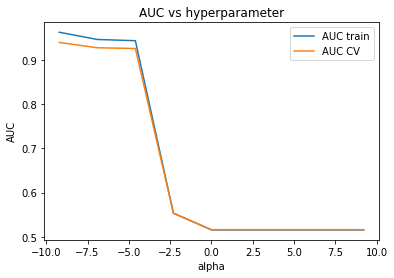

optimal alpha for which auc is maximum :  0.0001


In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import math

alpha = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

train_auc = []
cv_auc = []

for i in alpha:
    model = SGDClassifier(alpha=i, loss = "hinge") 
    clf = CalibratedClassifierCV(model, cv=3)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_alpha= alpha[cv_auc.index(max(cv_auc))]
alpha=[math.log(x) for x in alpha]

#plot auc vs alpha
x = plt.subplot( )
x.plot(alpha, train_auc, label='AUC train')
x.plot(alpha, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_alpha)

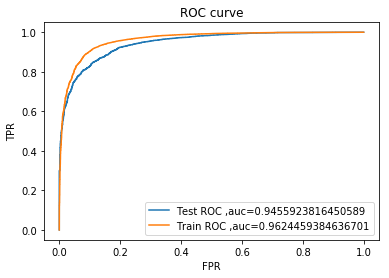

AUC on Test data is 0.9455923816450589
AUC on Train data is 0.9624459384636701
---------------------------


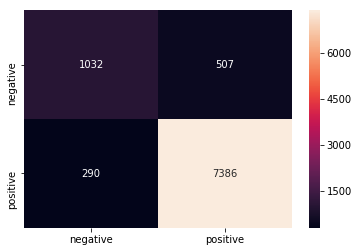

In [0]:
#Testing AUC on Test data
model = SGDClassifier(alpha = optimal_alpha)
clf = CalibratedClassifierCV(model, cv=3)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")



In [0]:
results=pd.DataFrame(columns=['Featuraization', 'Classifier' ,'alpha', 'Train-AUC', 'Test-AUC' ])
new = ['BOW','SGDClassifier-hinge loss',0.0001,0.9624,0.9455]
results.loc[0] = new

In [0]:
from sklearn.linear_model import SGDClassifier

# top 10 positive features
features = count_vect.get_feature_names()
clf = SGDClassifier(alpha=0.0001)
clf.fit(X_train,y_train)
weight = clf.coef_
positive_index=np.argsort(weight)[:,::-1]

negative_index=np.argsort(weight)

print('Top 10 positive features :')
for i in list(positive_index[0][0:10]):
    print(features[i])
    
print("----------------")

#top 10 negative features
print('Top 10 negative features :')
for i in list(negative_index[0][0:10]):
    print(features[i])

Top 10 positive features :
delicious
best
great
nice
amazing
loves
perfect
wonderful
excellent
love
----------------
Top 10 negative features :
worst
disappointed
horrible
terrible
disappointing
awful
return
threw
money
bland


### [5.1.2] Applying Linear SVM on TFIDF

In [0]:
X_train, X_test, y_train, y_test = train_test_split(final_tf_idf,final['Score'].values,test_size=0.2,shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

#Normalize Data
X_cv = preprocessing.normalize(X_cv)
print("CV Data size:", X_cv.shape)

Train Data Size:  (29484, 27311)
Test Data Size:  (9215, 27311)
CV Data size: (7372, 27311)


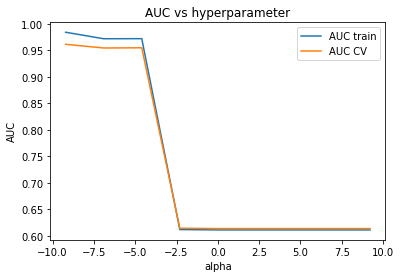

optimal alpha for which auc is maximum :  0.0001


In [0]:
alpha = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

train_auc = []
cv_auc = []

for i in alpha:
    model = SGDClassifier(alpha=i, loss = "hinge") 
    clf = CalibratedClassifierCV(model, cv=3)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_alpha= alpha[cv_auc.index(max(cv_auc))]
alpha=[math.log(x) for x in alpha]

#plot auc vs alpha
x = plt.subplot( )
x.plot(alpha, train_auc, label='AUC train')
x.plot(alpha, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_alpha)

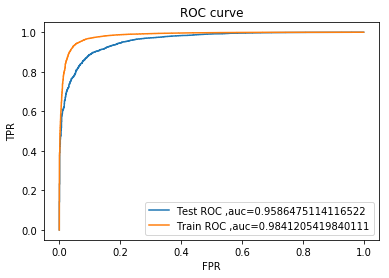

AUC on Test data is 0.9586475114116522
AUC on Train data is 0.9841205419840111
---------------------------


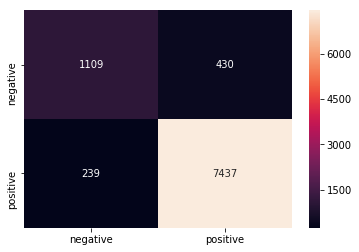

In [0]:
#Testing AUC on Test data
model = SGDClassifier(alpha = optimal_alpha)
clf = CalibratedClassifierCV(model, cv=3)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")


In [0]:
new = ['tf-idf','SGDClassifier-hinge loss',0.0001,0.9841,0.9586]
results.loc[1] = new

In [0]:
# top 10 positive features
features = tf_idf_vect.get_feature_names()
clf = SGDClassifier(alpha=0.0001)
clf.fit(X_train,y_train)
weight = clf.coef_
positive_index=np.argsort(weight)[:,::-1]

negative_index=np.argsort(weight)

print('Top 10 positive features :')
for i in list(positive_index[0][0:10]):
    print(features[i])
    
print("----------------")

#top 10 negative features
print('Top 10 negative features :')
for i in list(negative_index[0][0:10]):
    print(features[i])

Top 10 positive features :
great
good
best
not disappointed
delicious
love
loves
nice
amazing
wonderful
----------------
Top 10 negative features :
disappointed
worst
disappointing
horrible
not
terrible
not recommend
not worth
awful
not buy


### [5.1.3] Applying Linear SVM on AVG W2V

In [0]:
avg_vec_google = np.array(sent_vectors)

In [0]:
mask = ~np.any(np.isnan(avg_vec_google), axis=1)
# print(mask)
avg_vec_google_new = avg_vec_google[mask]
df_sample_new = final['Score'][mask]
print(avg_vec_google_new.shape)
print(df_sample_new.shape)

(46071, 50)
(46071,)


In [0]:
#Normalizing the data
avg_vec_norm = preprocessing.normalize(avg_vec_google_new)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,df_sample_new.values,test_size=0.2,shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

#Normalize Data
X_cv = preprocessing.normalize(X_cv)
print("CV Data size:", X_cv.shape)

Train Data Size:  (29484, 50)
Test Data Size:  (9215, 50)
CV Data size: (7372, 50)


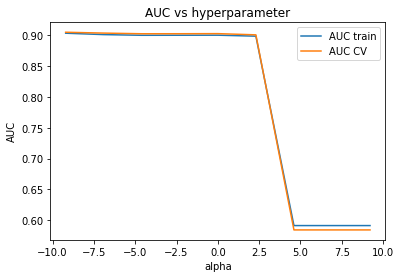

optimal alpha for which auc is maximum :  0.0001


In [0]:
alpha = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

train_auc = []
cv_auc = []

for i in alpha:
    model = SGDClassifier(alpha=i, loss = "hinge") 
    clf = CalibratedClassifierCV(model, cv=3)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_alpha= alpha[cv_auc.index(max(cv_auc))]
alpha=[math.log(x) for x in alpha]

#plot auc vs alpha
x = plt.subplot( )
x.plot(alpha, train_auc, label='AUC train')
x.plot(alpha, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_alpha)

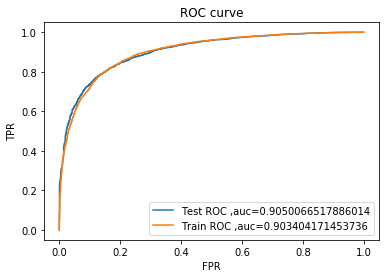

AUC on Test data is 0.9050066517886014
AUC on Train data is 0.903404171453736
---------------------------


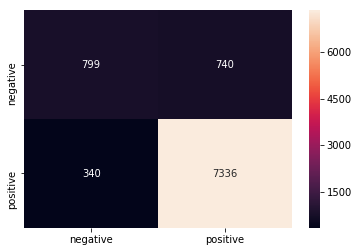

In [0]:
#Testing AUC on Test data
model = SGDClassifier(alpha = optimal_alpha)
clf = CalibratedClassifierCV(model, cv=3)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")


In [0]:
new = ['AVG W2V','SGDClassifier-hinge loss',0.0001,0.9034,0.9050]
results.loc[2] = new

### [5.1.4] Applying Linear SVM on TFIDF W2V

In [0]:
tfidf_w2v_vec_google = np.array(tfidf_sent_vectors)

In [0]:
tfidfw2v_vecs_norm = preprocessing.normalize(tfidf_w2v_vec_google)
X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,final['Score'].values,test_size=0.2,shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

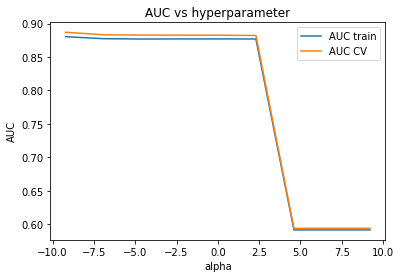

optimal alpha for which auc is maximum :  0.0001


In [0]:
alpha = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

train_auc = []
cv_auc = []

for i in alpha:
    model = SGDClassifier(alpha=i, loss = "hinge") 
    clf = CalibratedClassifierCV(model, cv=3)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_alpha= alpha[cv_auc.index(max(cv_auc))]
alpha=[math.log(x) for x in alpha]

#plot auc vs alpha
x = plt.subplot( )
x.plot(alpha, train_auc, label='AUC train')
x.plot(alpha, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_alpha)

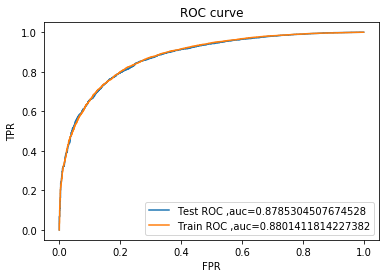

AUC on Test data is 0.8785304507674528
AUC on Train data is 0.8801411814227382
---------------------------


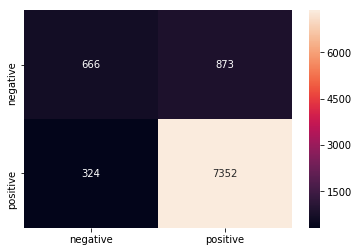

In [0]:
#Testing AUC on Test data
model = SGDClassifier(alpha = optimal_alpha)
clf = CalibratedClassifierCV(model, cv=3)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ['tf-idf W2V','SGDClassifier-hinge loss',0.0001,0.8801,0.8785]
results.loc[3] = new

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW

In [0]:
X=preprocessed_reviews
y=np.array(final['Score'])
X=X[:30000]
y=y[:30000]

In [0]:
#BoW
count_vect = CountVectorizer(min_df=10, max_features=500) #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 500)
the number of unique words  500


In [0]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final_counts,final['Score'].values,test_size=0.2,shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)


#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

X_cv = preprocessing.normalize(X_cv)
print("CV Data Size :", X_cv.shape)

Train Data Size:  (29484, 500)
Test Data Size:  (9215, 500)
CV Data Size : (7372, 500)


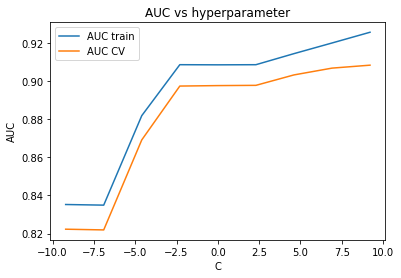

optimal C for which auc is maximum :  [9.210340371976184, 6.907755278982137, 4.605170185988092, 2.302585092994046, 0.0, -2.3025850929940455, -4.605170185988091, -6.907755278982137, -9.210340371976182]


In [0]:
from sklearn.svm import SVC
C = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

train_auc = []
cv_auc = []

for i in C:
    model = SVC(C=i) 
    clf = CalibratedClassifierCV(model, cv=3)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_C= C[cv_auc.index(max(cv_auc))]
C=[math.log(x) for x in C]

#plot auc vs alpha
x = plt.subplot( )
x.plot(C, train_auc, label='AUC train')
x.plot(C, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal C for which auc is maximum : ',C)

In [0]:
print('optimal C for which auc is maximum : ',optimal_C)

optimal C for which auc is maximum :  10000


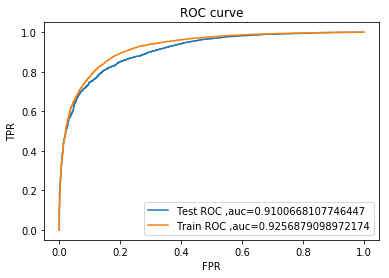

AUC on Test data is 0.9100668107746447
AUC on Train data is 0.9256879098972174
---------------------------


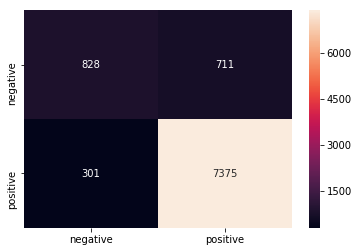

In [0]:
#Testing AUC on Test data
model =SVC(C = optimal_C)
clf = CalibratedClassifierCV(model, cv=3)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
results_2=pd.DataFrame(columns=['Featuraization', 'Classifier','C' , 'Train-AUC', 'Test-AUC' ])

In [0]:
new = ["Bow","RBF",10000,0.9256,0.9100]
results_2.loc[0] = new

### [5.2.2] Applying RBF SVM on TFIDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 500)
the number of unique words including both unigrams and bigrams  500


In [0]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final_counts,final['Score'].values,test_size=0.2,shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)


#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

X_cv = preprocessing.normalize(X_cv)
print("CV Data Size :", X_cv.shape)

Train Data Size:  (29484, 500)
Test Data Size:  (9215, 500)
CV Data Size : (7372, 500)


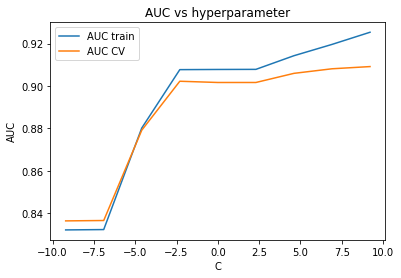

optimal C for which auc is maximum :  10000


In [0]:
from sklearn.svm import SVC
C = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

train_auc = []
cv_auc = []

for i in C:
    model = SVC(C=i) 
    clf = CalibratedClassifierCV(model, cv=3)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_C= C[cv_auc.index(max(cv_auc))]
C=[math.log(x) for x in C]

#plot auc vs alpha
x = plt.subplot( )
x.plot(C, train_auc, label='AUC train')
x.plot(C, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal C for which auc is maximum : ',optimal_C)

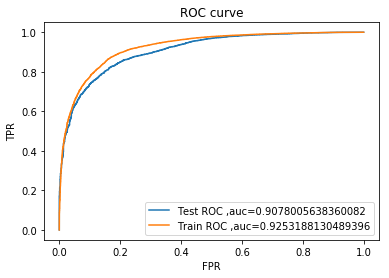

AUC on Test data is 0.9078005638360082
AUC on Train data is 0.9253188130489396
---------------------------


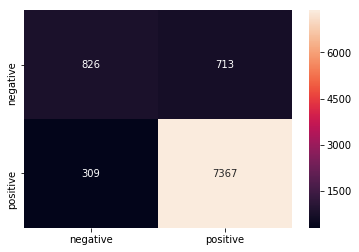

In [0]:
#Testing AUC on Test data
model =SVC(C = optimal_C)
clf = CalibratedClassifierCV(model, cv=3)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ["tf-idf","RBF",10000,0.9253,0.9078]
results_2.loc[1] = new

### [5.2.3] Applying RBF SVM on AVG W2V

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X:
    list_of_sentance.append(sentance.split())

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 30000/30000 [00:53<00:00, 555.74it/s]

30000
50


In [0]:
avg_vec_google = np.array(sent_vectors)

In [0]:
mask = ~np.any(np.isnan(avg_vec_google), axis=1)
# print(mask)
avg_vec_google_new = avg_vec_google[mask]
df_sample_new = y[mask]
print(avg_vec_google_new.shape)
print(df_sample_new.shape)

(30000, 50)
(30000,)


In [0]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Normalizing the data
avg_vec_norm = preprocessing.normalize(avg_vec_google_new)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,df_sample_new,test_size=0.2,shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

#Normalize Data
X_cv = preprocessing.normalize(X_cv)
print("CV Data size:", X_cv.shape)

Train Data Size:  (19200, 50)
Test Data Size:  (6000, 50)
CV Data size: (4800, 50)


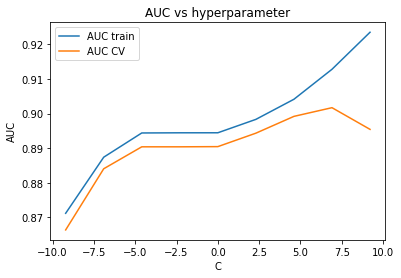

optimal C for which auc is maximum :  1000


In [0]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import math

C = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

train_auc = []
cv_auc = []

for i in C:
    model = SVC(C=i) 
    clf = CalibratedClassifierCV(model, cv=3)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_C= C[cv_auc.index(max(cv_auc))]
C=[math.log(x) for x in C]

#plot auc vs alpha
x = plt.subplot( )
x.plot(C, train_auc, label='AUC train')
x.plot(C, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal C for which auc is maximum : ',optimal_C)

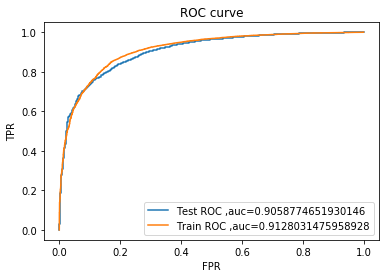

AUC on Test data is 0.9058774651930146
AUC on Train data is 0.9128031475958928
---------------------------


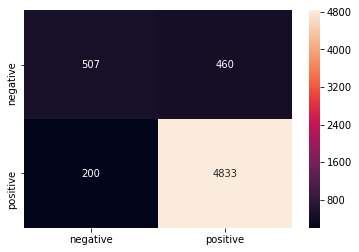

In [0]:
from sklearn.metrics import confusion_matrix

#Testing AUC on Test data
model =SVC(C = optimal_C)
clf = CalibratedClassifierCV(model, cv=3)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ["AVG W2V","RBF",1000,0.9128,0.9058]
results_2.loc[2] = new

### [5.2.4] Applying RBF SVM on TFIDF W2V

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [10:41<00:00, 46.77it/s]


In [0]:
tfidf_w2v_vec_google = np.array(tfidf_sent_vectors)

In [0]:
tfidfw2v_vecs_norm = preprocessing.normalize(tfidf_w2v_vec_google)
X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,y,test_size=0.2,shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)
print ("Train Data",X_train.shape)
print("Test Data",X_test.shape)
print("CV Data",X_cv.shape)

Train Data (19200, 50)
Test Data (6000, 50)
CV Data (4800, 50)


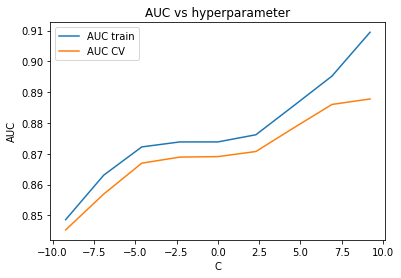

optimal C for which auc is maximum :  10000


In [0]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import math

C = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

train_auc = []
cv_auc = []

for i in C:
    model = SVC(C=i) 
    clf = CalibratedClassifierCV(model, cv=3)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_C= C[cv_auc.index(max(cv_auc))]
C=[math.log(x) for x in C]

#plot auc vs alpha
x = plt.subplot( )
x.plot(C, train_auc, label='AUC train')
x.plot(C, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal C for which auc is maximum : ',optimal_C)

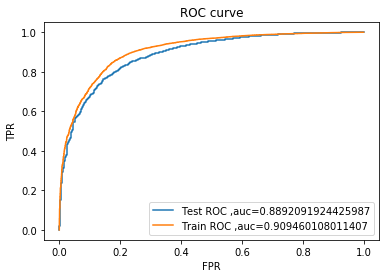

AUC on Test data is 0.8892091924425987
AUC on Train data is 0.909460108011407
---------------------------


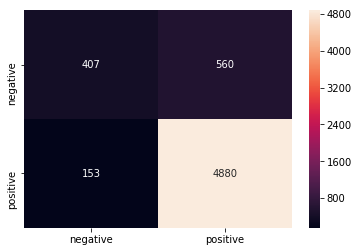

In [0]:
from sklearn.metrics import confusion_matrix

#Testing AUC on Test data
model =SVC(C = optimal_C)
clf = CalibratedClassifierCV(model, cv=3)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ["tfidf W2V","RBF",10000,0.9094,0.8892]
results_2.loc[3] = new

## Performance Table

In [0]:
results

,Featuraization,Classifier,alpha,Train-AUC,Test-AUC
0,BOW,SGDClassifier-hinge loss,0.0001,0.9624,0.9455
1,tf-idf,SGDClassifier-hinge loss,0.0001,0.9841,0.9586
2,AVG W2V,SGDClassifier-hinge loss,0.0001,0.9034,0.9050
3,tf-idf W2V,SGDClassifier-hinge loss,0.0001,0.8801,0.8785


In [0]:
results_2

,Featuraization,Classifier,C,Train-AUC,Test-AUC
0,Bow,RBF,10000,0.9256,0.9100
1,tf-idf,RBF,10000,0.9253,0.9078
2,AVG W2V,RBF,1000,0.9128,0.9058
3,tfidf W2V,RBF,10000,0.9094,0.8892


## [6] Conclusions

1.Support Vector Machine(SVM) gave the best result

2.Linear SVM gave best result better then RBF SVM

3.Linear SVM gave best result AUC = 0.9586   with tfidf featuraization and alpha = 0.0001

4.RBF SVM training time complexity is high compared to Linear SVM